# COVID-19 Final Model

### Introduction
### Initial Model Tuning - Image Augmentation
### Initial Model Tuning - Learning Rate Scheduler
### InceptionV3 - Image Augmentation
### InceptionV3 - Learning Rate Scheduler
### InceptionResNetV2 - Image Augmentation
### InceptionResNetV2 - Learning Rate Scheduler
### Final Model
### Further Exploration

### Introduction

In the first phase of this project, we created an initial model that achieved over 90% accuracy in just 15 epochs. In the second phase, we tested several pretrained models - DenseNet169, InceptionV3, ResNet50, VGG16, and InceptionResNetV2 - in hopes that at least one of them could achieve a higher accuracy than our inital model. To summarize, we found that in addition to our inital model, InceptionV3 and InceptionResNetV2 were our most promising models, all achieving over 90% accuracy on test sets. We'll now be tuning all three of those models to determine which can reach an accuracy closest to 100%.

The initial model can be found here: https://github.com/kjd999/Additional-Projects/blob/master/COVID%20Image%20Recognition/COVID_Initial_Model.ipynb

And the first runs of the pretrained models are here: https://github.com/kjd999/Additional-Projects/blob/master/COVID%20Image%20Recognition/COVID_Pretrained_Models_First_Run.ipynb

A little background in case you haven't viewed the notebooks containing the inital model or pretrained models:

This project is influenced by Thomas Mann's *The Magic Mountain*, in which protagonist Hans Castorp spends seven years at a sanatorium that treats tuberculosis patients in the early part of the 20th century. Mann describes the chest x-ray images of patients in great detail, with Dr. Behrens explaining to Hans Castorp which telltale signs in the images indicate tuberculosis.

While tuberculosis is still a significant ailment in many parts of the world, this project is concerned with a more topical disease - COVID-19. While there are several tests available to test for COVID-19, x-ray imaging still plays a vital role in understanding the damage that COVID can wreak on a patient's lungs.

COVID can cause patients to develop pneumonia. There is a great deal of research being done to determine how COVID based pnuemonia differs from non-COVID pnuemonia. While COVID and non-COVID pneumonias are both viral, there are some distinguishing features of the COVID variety, including a ground glass appearance on CT scans and that it affects both lungs rather than just one (non-COVID pneumonias can also effect both lungs, but less consistently).

This project will attempt to train a model to distinuish among the lungs of COVID, viral (non-COVID) pneumonia, and healthy patients (or at least those that don't have either type of pneumonia).

We'll be working with over 3800 images collected from a variety of sources, all of which can be found here: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

As we did previously, let's begin by loading any libraries we may need, including tensorflow, keras, pandas, numpy, and matplotlib.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Add a couple of random seeds to make our outcomes more consistent.

In [ ]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(99)
tf.random.set_seed(99)   

Since this is being done on Colab, we'll mount the images from Google Drive. There are other ways to also load the images, depending on which application you're using.

In [ ]:
# Mount Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As a reminder, the following sets of images are chest x-rays of COVID patients, followed by pneumonia and healthy (labeled as NORMAL) patients.

Display random COVID patient images


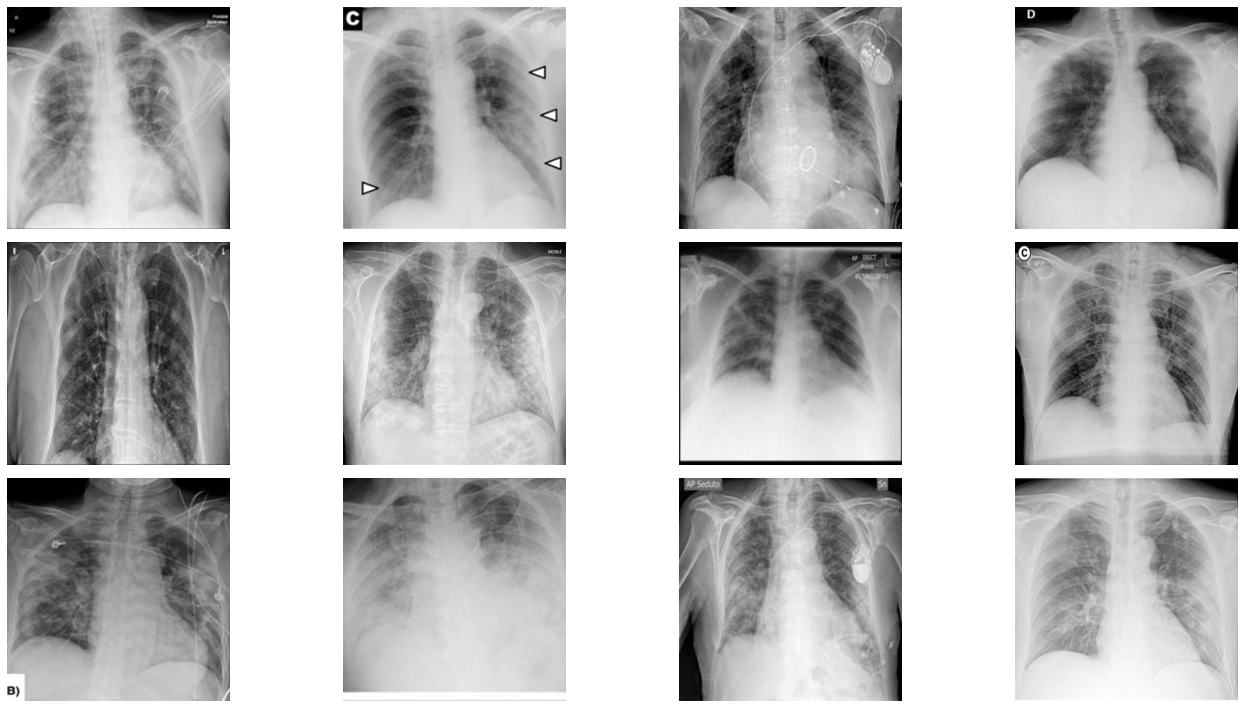

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/COVID"
image_files = os.listdir(path)


print('Display random COVID patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random viral pneumonia patient images


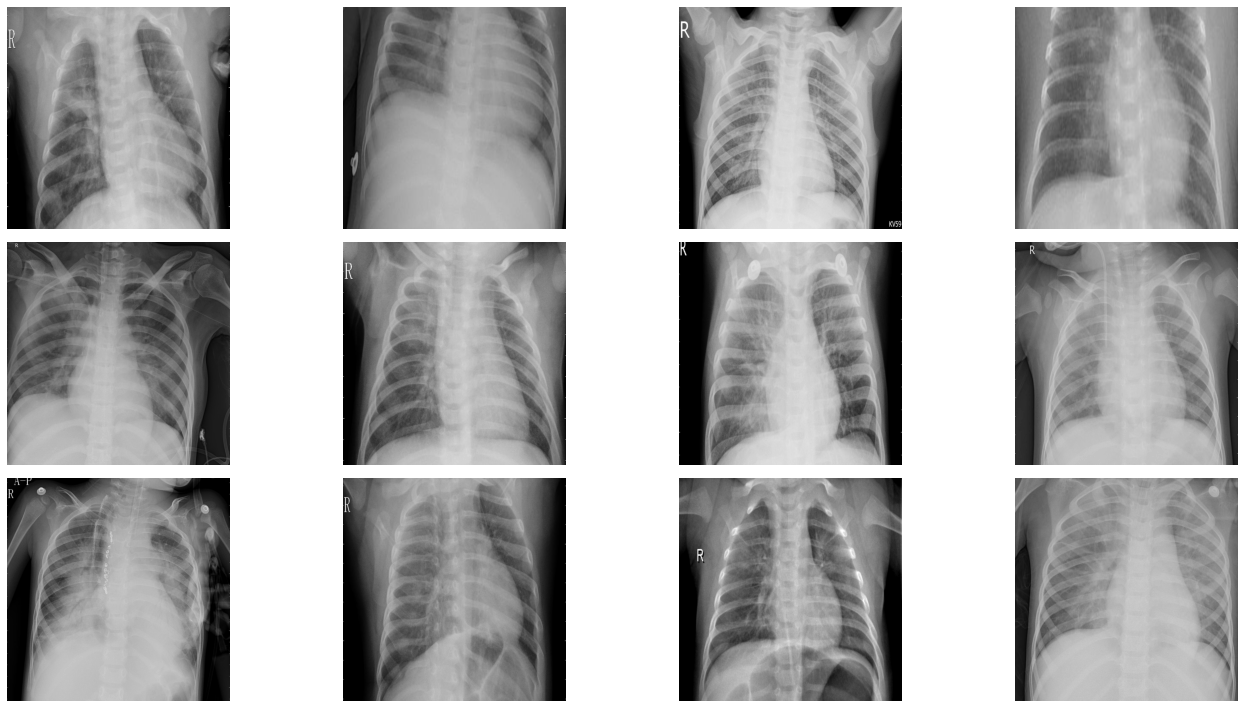

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/Viral Pneumonia"
image_files = os.listdir(path)


print('Display random viral pneumonia patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random normal patient images


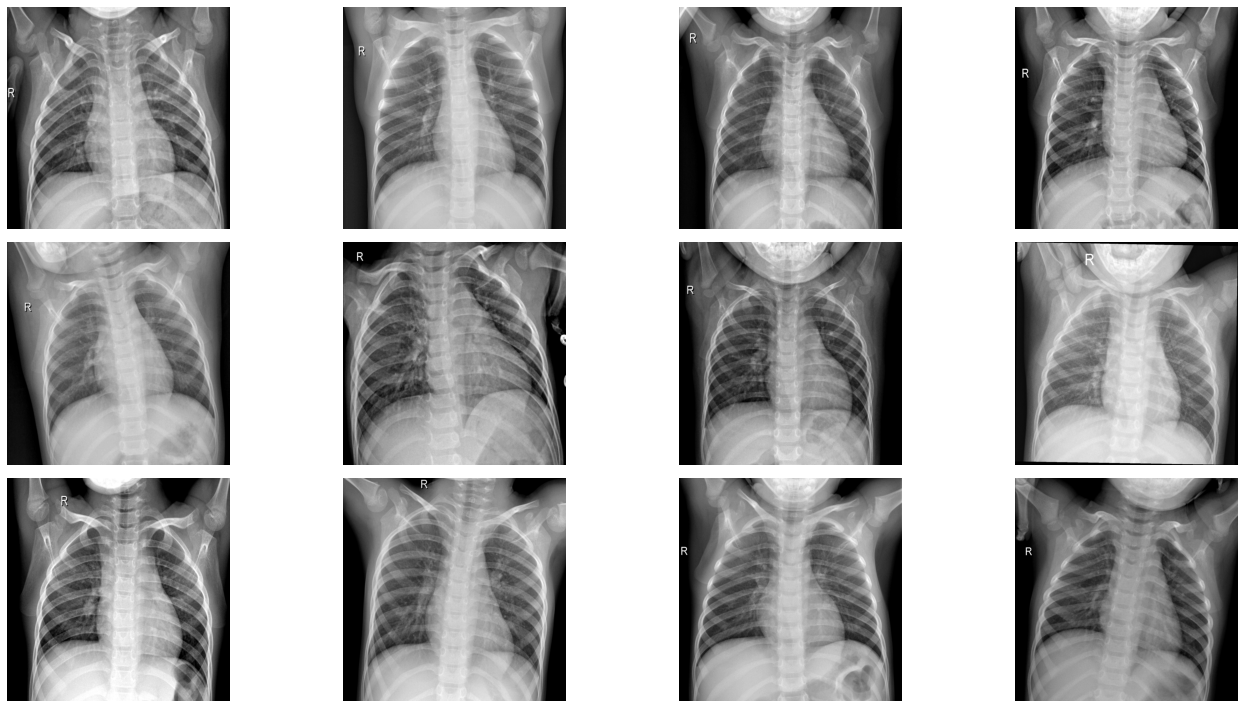

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/NORMAL"
image_files = os.listdir(path)


print('Display random normal patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

As we can see, there are some similarities between the COVID and pneumonia patients, particularly with regard to the cloudy appearance of the scans. However, the COVID patients on average seem to have the cloudiest images, while the healthy patients have the clearest.

### Initial Model Tuning - Image Augmentation

For the sake time, we'll be sticking to just two common tuning techniques - image augmentation and learning rate scheduling. We'll begin with image augmentation and dicuss learning rate scheduling later in  the notebook.

While there are several hyperparameters that we can change, only a few really make sense in the current context - horizontal flip, height_shift, width_shift, and zoom range.

Chest x-rays are fairly symmetrical, other than the fact that the heart is slightly off center. Thus, a horizontal flip may be useful. We can also tell that the images are not all centered. So, genetrating more slightly shifted images can help. finally, not all of the chests are the same size. As such, applying a zoom factor could also increase accuracy.

Other hyperparameters just woundn't be helpful. The images are all right side up, so a vertical flip would likely confuse the model. A smiliar confusion would likely result from rotated images.

In [ ]:
# Import ImageDataGenerator to allow us to create batches and perform data augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip=True,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          zoom_range=0.15)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Paths to access the correct image folders
train_path = '/content/drive/MyDrive/COVID-19 Radiography Database/train'
valid_path = '/content/drive/MyDrive/COVID-19 Radiography Database/validation'
test_path = '/content/drive/MyDrive/COVID-19 Radiography Database/test'

We'll now use image generator to define where our train, validation, and test images are found as well as to dictate image size and batch size. The orignal images size is 256 x 256, most of our pretrained models work with 224 x 224 images. We're running a 60/20/20 split (train/validation/test).

In [ ]:
train_batches = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(128, 128), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
# Function to graph training and validation accuracy/loss results
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure(figsize=(15, 7))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
model = keras.Sequential([
    # Block 1
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Fully-connected NN
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(3, activation='softmax')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

In [ ]:
# Complile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='initial_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      callbacks=callbacks_list,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 1194s 16s/step - loss: 2.3899 - accuracy: 0.6981 - val_loss: 1.1493 - val_accuracy: 0.5735

Epoch 00001: val_loss improved from inf to 1.14934, saving model to initial_model.h5
Epoch 2/15
73/73 [==============================] - 42s 569ms/step - loss: 0.3240 - accuracy: 0.8844 - val_loss: 1.2123 - val_accuracy: 0.6044

Epoch 00002: val_loss did not improve from 1.14934
Epoch 3/15
73/73 [==============================] - 41s 566ms/step - loss: 0.2839 - accuracy: 0.9011 - val_loss: 1.2816 - val_accuracy: 0.6456

Epoch 00003: val_loss did not improve from 1.14934
Epoch 4/15
73/73 [==============================] - 41s 567ms/step - loss: 0.2918 - accuracy: 0.8946 - val_loss: 0.6581 - val_accuracy: 0.6830

Epoch 00004: val_loss improved from 1.14934 to 0.65808, saving model to initial_model.h5
Epoch 5/15
73/73 [==============================] - 41s 561ms/step - loss: 0.2344 - accuracy: 0.9186 - val_loss: 1.1107 - val_accuracy: 0.6559

Epoc

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model.save("initial_model.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
initial_model = load_model('initial_model.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = initial_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 297s 12s/step - loss: 10.4611 - accuracy: 0.3252
test loss: 10.461119651794434
test acc: 0.32516127824783325


Our accuracy was far worse with image augmentation than without it, recalling that our inital model originally had a test accuracy in the 90's. We'll next run a learning rate scheduler but without also using image augmentation.

### Initial Model Tuning - Learning Rate Scheduler

Next, we're going to use a learning rate scheduler to find the optimal learning rate for our model. In particular, we're going to include it in our callbacks list (along with ModelCheckpoint) through the implementation of ReduceLROnPlateau.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
# Rescale the images without image augmentation
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
model = keras.Sequential([
    # Block 1
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Fully-connected NN
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(3, activation='softmax')  
])

In [ ]:
# Complile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='initlr.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ), 
    keras.callbacks.ReduceLROnPlateau(
        factor=0.3, patience=3)
]

n_epochs=20

history = model.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=n_epochs,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      callbacks=callbacks_list,
      verbose=1)

Epoch 1/20
73/73 [==============================] - 42s 568ms/step - loss: 2.8668 - accuracy: 0.6878 - val_loss: 1.1243 - val_accuracy: 0.6031

Epoch 00001: val_loss improved from inf to 1.12434, saving model to initlr.h5
Epoch 2/20
73/73 [==============================] - 41s 562ms/step - loss: 0.3991 - accuracy: 0.8570 - val_loss: 0.9723 - val_accuracy: 0.6314

Epoch 00002: val_loss improved from 1.12434 to 0.97233, saving model to initlr.h5
Epoch 3/20
73/73 [==============================] - 41s 566ms/step - loss: 0.2806 - accuracy: 0.8972 - val_loss: 0.9132 - val_accuracy: 0.6456

Epoch 00003: val_loss improved from 0.97233 to 0.91323, saving model to initlr.h5
Epoch 4/20
73/73 [==============================] - 41s 566ms/step - loss: 0.2358 - accuracy: 0.9233 - val_loss: 1.2078 - val_accuracy: 0.6469

Epoch 00004: val_loss did not improve from 0.91323
Epoch 5/20
73/73 [==============================] - 41s 565ms/step - loss: 0.2187 - accuracy: 0.9195 - val_loss: 0.9883 - val_accur

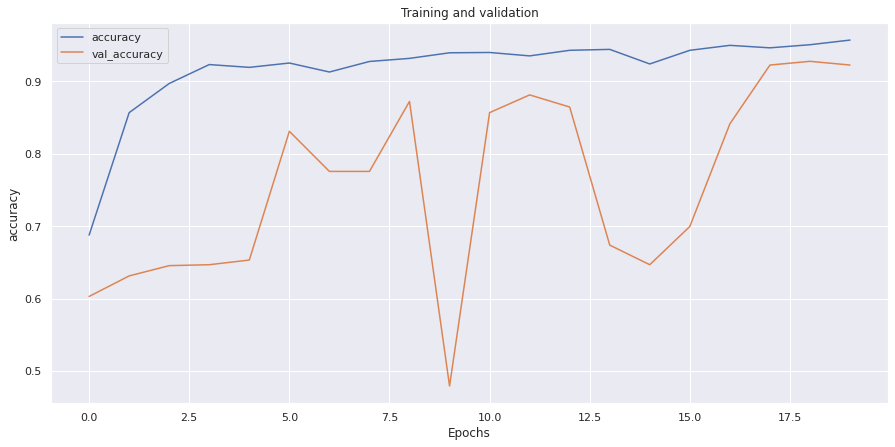

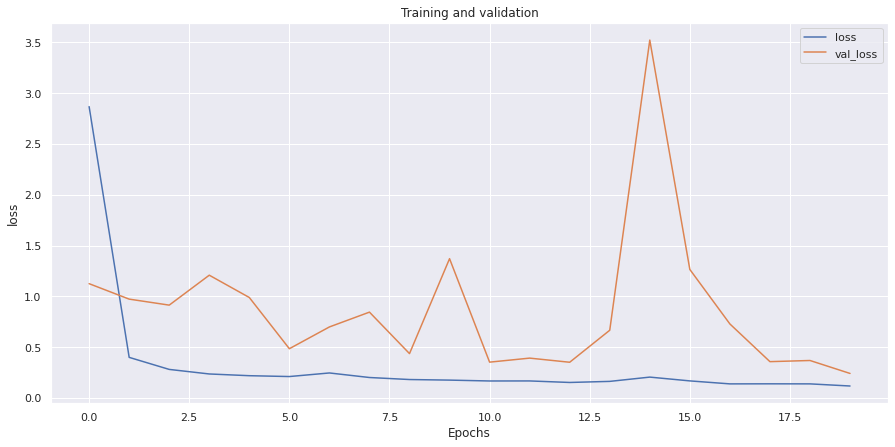

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model.save("initlr.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
initlr_model = load_model('initlr.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = initlr_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 10s 380ms/step - loss: 0.3039 - accuracy: 0.9252
test loss: 0.30393487215042114
test acc: 0.9251613020896912


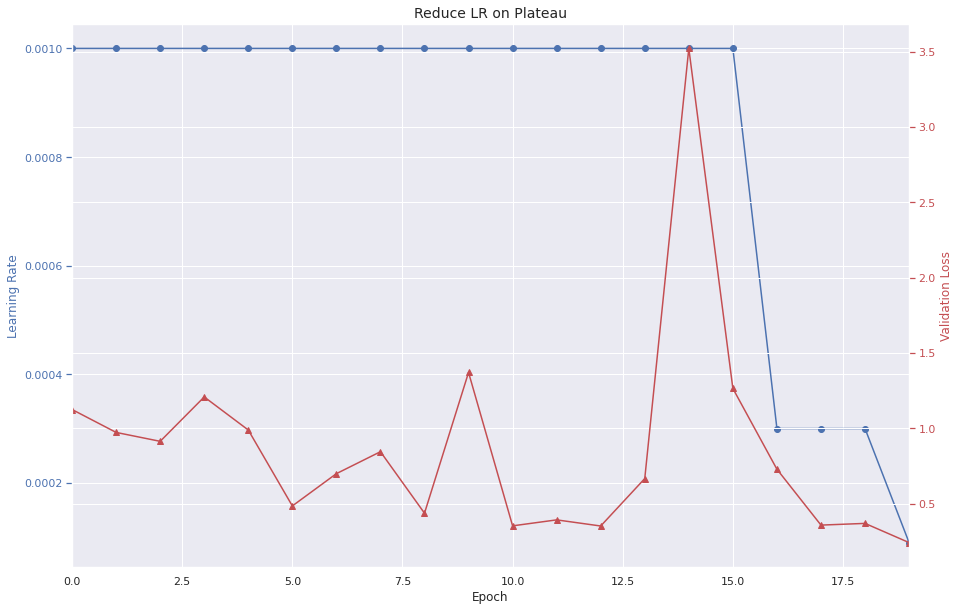

In [ ]:
# Graph learning rate scheduler results
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

Our accuracy is comparable to when we ran the model initially. Notice in the graph above that the validation loss is at its lowest at a learning rate of 0.0001. If this ends up being our best model, we may rerun the model with that new learning rate.

Now, we'll repeat this process with both InceptionV3 and InceptionResNetV2. First up, InceptionV3. We'll begin by changing the image input size to 224x224 and using the same image augmentation values as above. 

### InceptionV3 - Image Augmentation

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip=True,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          zoom_range=0.15)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
train_batches_iv3 = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches_iv3 = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches_iv3 = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
iv3 = tf.keras.applications.InceptionV3(
                  include_top=False,
                  input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#Adjust several layers
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_iv3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 34,911,011
Trainable params: 34,876,579
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model_iv3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='iv3.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_iv3.fit(train_batches_iv3, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches_iv3, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 73s 885ms/step - loss: 1.6476 - accuracy: 0.7413 - val_loss: 275.6094 - val_accuracy: 0.5438

Epoch 00001: val_loss improved from inf to 275.60941, saving model to iv3.h5
Epoch 2/15
73/73 [==============================] - 60s 818ms/step - loss: 0.3616 - accuracy: 0.9028 - val_loss: 0.7640 - val_accuracy: 0.7474

Epoch 00002: val_loss improved from 275.60941 to 0.76402, saving model to iv3.h5
Epoch 3/15
73/73 [==============================] - 60s 819ms/step - loss: 0.1686 - accuracy: 0.9469 - val_loss: 0.4684 - val_accuracy: 0.8454

Epoch 00003: val_loss improved from 0.76402 to 0.46842, saving model to iv3.h5
Epoch 4/15
73/73 [==============================] - 60s 820ms/step - loss: 0.1688 - accuracy: 0.9465 - val_loss: 0.2738 - val_accuracy: 0.9188

Epoch 00004: val_loss improved from 0.46842 to 0.27376, saving model to iv3.h5
Epoch 5/15
73/73 [==============================] - 60s 821ms/step - loss: 0.1355 - accuracy: 0.9555 - val

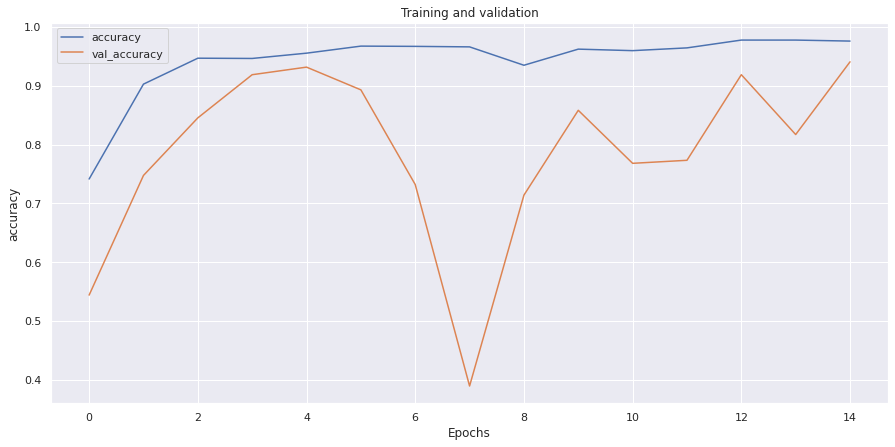

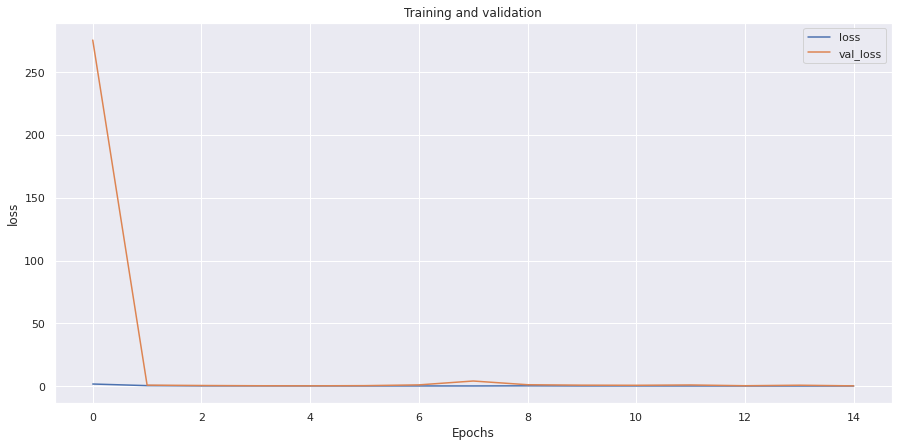

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_iv3.save("iv3.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3_model = load_model('iv3.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = iv3_model.evaluate(test_batches_iv3, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 13s 463ms/step - loss: 0.2361 - accuracy: 0.9071
test loss: 0.2361384481191635
test acc: 0.907096803188324


This isn't an improvement over the previous run with this same model. So, for the learning rate scheduler, we'll resort back to not using any form of image augmentation.

### InceptionV3 - Learning Rate Scheduler

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
iv3lr = tf.keras.applications.InceptionV3(
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
#Adjust several layers
model_iv3lr = tf.keras.Sequential()
model_iv3lr.add(iv3lr)
model_iv3lr.add(tf.keras.layers.Flatten())
model_iv3lr.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3lr.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_iv3lr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='iv3lr.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ), 
    keras.callbacks.ReduceLROnPlateau(
        factor=0.3, patience=3)
]

n_epochs=20

history = model_iv3lr.fit(
      train_batches_iv3,
      steps_per_epoch=73,
    
      epochs=n_epochs,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches_iv3,
      validation_steps=25,
      callbacks=callbacks_list,
      verbose=1)

Epoch 1/20
73/73 [==============================] - 67s 840ms/step - loss: 2.1460 - accuracy: 0.7709 - val_loss: 432.7666 - val_accuracy: 0.2912

Epoch 00001: val_loss improved from inf to 432.76663, saving model to iv3lr.h5
Epoch 2/20
73/73 [==============================] - 60s 818ms/step - loss: 0.3525 - accuracy: 0.8852 - val_loss: 0.7048 - val_accuracy: 0.6972

Epoch 00002: val_loss improved from 432.76663 to 0.70478, saving model to iv3lr.h5
Epoch 3/20
73/73 [==============================] - 60s 815ms/step - loss: 0.2208 - accuracy: 0.9426 - val_loss: 0.8705 - val_accuracy: 0.7320

Epoch 00003: val_loss did not improve from 0.70478
Epoch 4/20
73/73 [==============================] - 60s 819ms/step - loss: 0.1967 - accuracy: 0.9302 - val_loss: 0.3741 - val_accuracy: 0.8711

Epoch 00004: val_loss improved from 0.70478 to 0.37407, saving model to iv3lr.h5
Epoch 5/20
73/73 [==============================] - 60s 819ms/step - loss: 0.2000 - accuracy: 0.9293 - val_loss: 0.3561 - val_ac

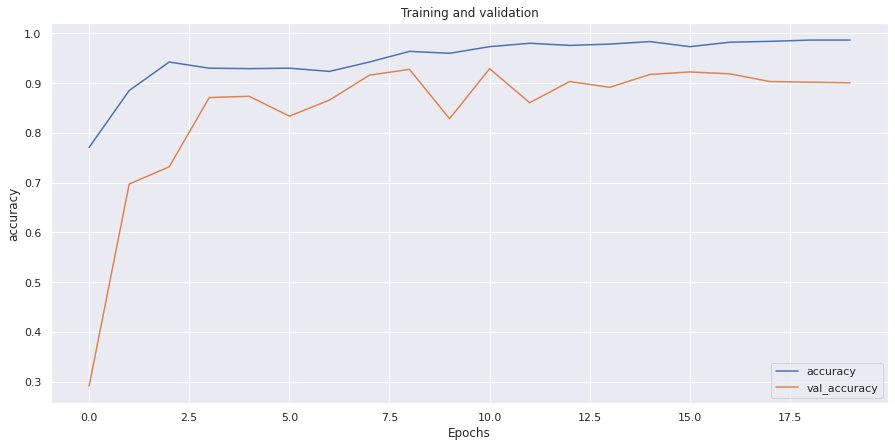

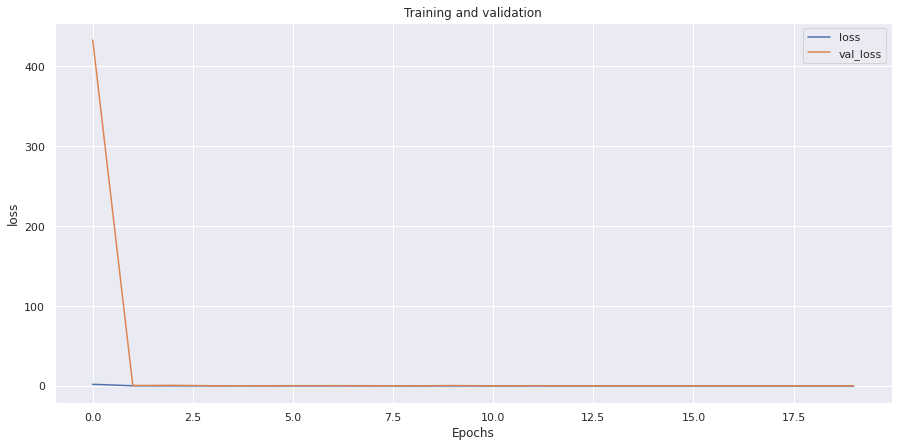

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_iv3lr.save("iv3lr.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3lr_model = load_model('iv3lr.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = iv3lr_model.evaluate(test_batches_iv3, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 426ms/step - loss: 0.5993 - accuracy: 0.8116
test loss: 0.5992927551269531
test acc: 0.8116129040718079


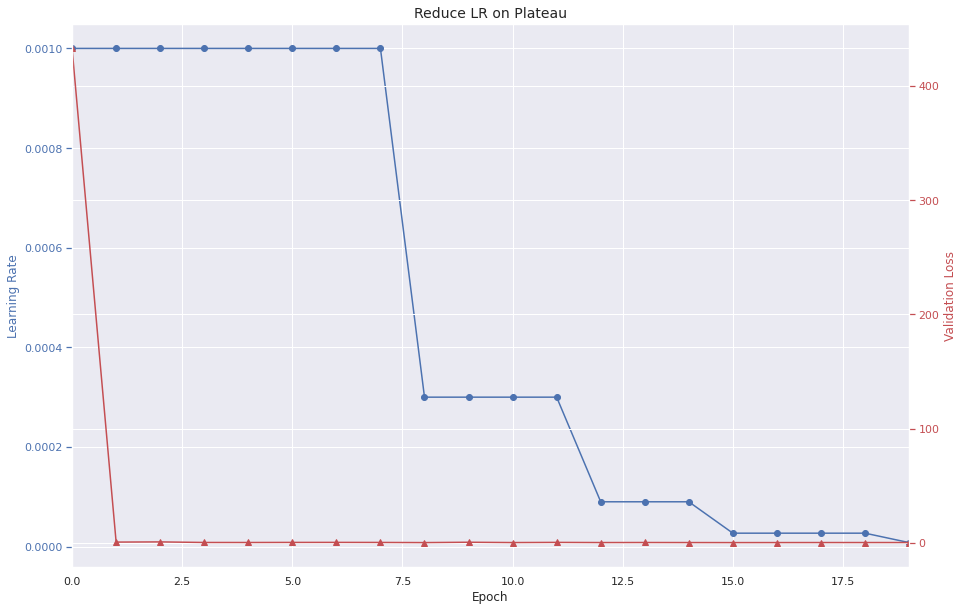

In [ ]:
# Graph learning rate scheduler results
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

Interestingly, the model dropped sharply in accuracy, and the validation loss stopped decreasing at a certain point regardless of the learning rate. For now, our initial model is still the best. Let's move next to InceptionResNetV2.

### InceptionResNetV2 - Image Augmentation

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
train_batches_irnv2 = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(299, 299), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches_irnv2 = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches_irnv2 = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
irnv2 = tf.keras.applications.InceptionResNetV2(
                  include_top=False,
                  input_shape=(299, 299, 3))

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model_irnv2 = tf.keras.Sequential()
model_irnv2.add(irnv2)
model_irnv2.add(tf.keras.layers.Flatten())
model_irnv2.add(tf.keras.layers.Dense(256, activation='relu'))
model_irnv2.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_irnv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25166080  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 79,503,587
Trainable params: 79,443,043
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
model_irnv2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='irnv2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_irnv2.fit(train_batches_irnv2, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches_irnv2, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 128s 1s/step - loss: 1.9242 - accuracy: 0.8634 - val_loss: 16.4513 - val_accuracy: 0.8312

Epoch 00001: val_loss improved from inf to 16.45133, saving model to irnv2.h5
Epoch 2/15
73/73 [==============================] - 99s 1s/step - loss: 0.6505 - accuracy: 0.8946 - val_loss: 1.0268 - val_accuracy: 0.6005

Epoch 00002: val_loss improved from 16.45133 to 1.02682, saving model to irnv2.h5
Epoch 3/15
73/73 [==============================] - 98s 1s/step - loss: 0.1735 - accuracy: 0.9400 - val_loss: 0.5732 - val_accuracy: 0.7912

Epoch 00003: val_loss improved from 1.02682 to 0.57320, saving model to irnv2.h5
Epoch 4/15
73/73 [==============================] - 98s 1s/step - loss: 0.8396 - accuracy: 0.9032 - val_loss: 63.9573 - val_accuracy: 0.2990

Epoch 00004: val_loss did not improve from 0.57320
Epoch 5/15
73/73 [==============================] - 98s 1s/step - loss: 0.1997 - accuracy: 0.9392 - val_loss: 10.0062 - val_accuracy: 0.4394


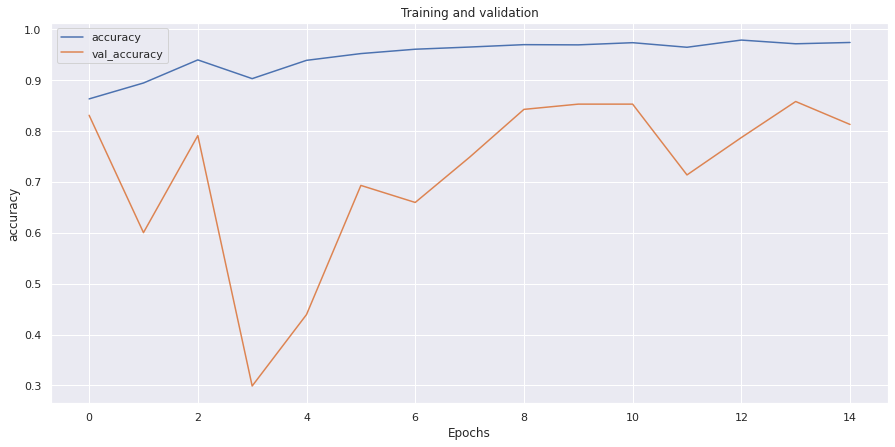

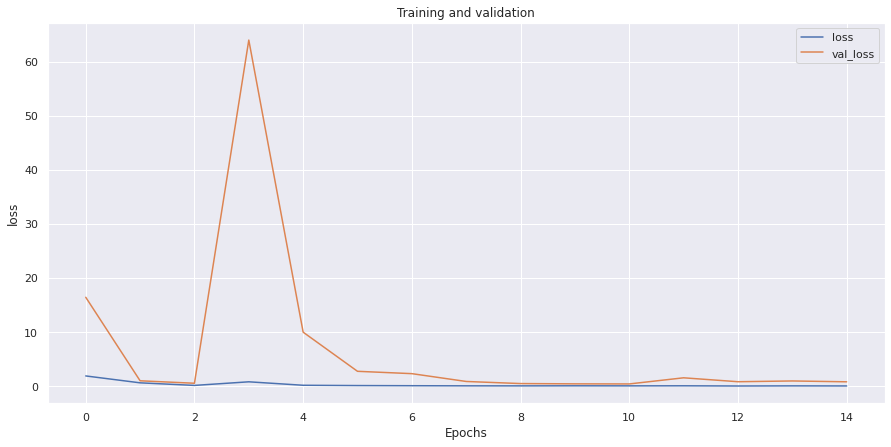

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_irnv2.save("irnv2.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
irnv2_model = load_model('irnv2.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = irnv2_model.evaluate(test_batches_irnv2, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 17s 546ms/step - loss: 1.7030 - accuracy: 0.7123
test loss: 1.7030253410339355
test acc: 0.7122580409049988


As with both of our previous models, image augmentation results in a decrease of accuracy. As such, we'll run the learning rate scheduler without it.

### InceptionResNetV2 - Learning Rate Scheduler

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
irnv2lr = tf.keras.applications.InceptionResNetV2(
                  include_top=False,
                  input_shape=(299, 299, 3))

In [ ]:
model_irnv2lr = tf.keras.Sequential()
model_irnv2lr.add(irnv2lr)
model_irnv2lr.add(tf.keras.layers.Flatten())
model_irnv2lr.add(tf.keras.layers.Dense(256, activation='relu'))
model_irnv2lr.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_irnv2lr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='irnv2lr.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ), 
    keras.callbacks.ReduceLROnPlateau(
        factor=0.3, patience=3)
]

n_epochs=20

history = model_irnv2lr.fit(
      train_batches_irnv2,
      steps_per_epoch=73,
    
      epochs=n_epochs,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches_irnv2,
      validation_steps=25,
      callbacks=callbacks_list,
      verbose=1)

Epoch 1/20
73/73 [==============================] - 113s 1s/step - loss: 2.7938 - accuracy: 0.8184 - val_loss: 2.7515 - val_accuracy: 0.5838

Epoch 00001: val_loss improved from inf to 2.75149, saving model to irnv2lr.h5
Epoch 2/20
73/73 [==============================] - 97s 1s/step - loss: 0.1707 - accuracy: 0.9512 - val_loss: 0.5586 - val_accuracy: 0.8286

Epoch 00002: val_loss improved from 2.75149 to 0.55863, saving model to irnv2lr.h5
Epoch 3/20
73/73 [==============================] - 97s 1s/step - loss: 0.0977 - accuracy: 0.9704 - val_loss: 0.3909 - val_accuracy: 0.8802

Epoch 00003: val_loss improved from 0.55863 to 0.39086, saving model to irnv2lr.h5
Epoch 4/20
73/73 [==============================] - 97s 1s/step - loss: 0.0883 - accuracy: 0.9709 - val_loss: 0.3404 - val_accuracy: 0.9034

Epoch 00004: val_loss improved from 0.39086 to 0.34041, saving model to irnv2lr.h5
Epoch 5/20
73/73 [==============================] - 98s 1s/step - loss: 0.0962 - accuracy: 0.9704 - val_los

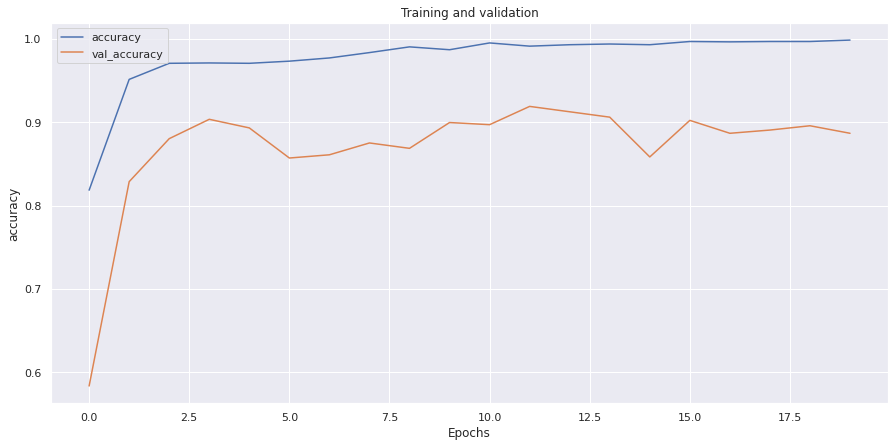

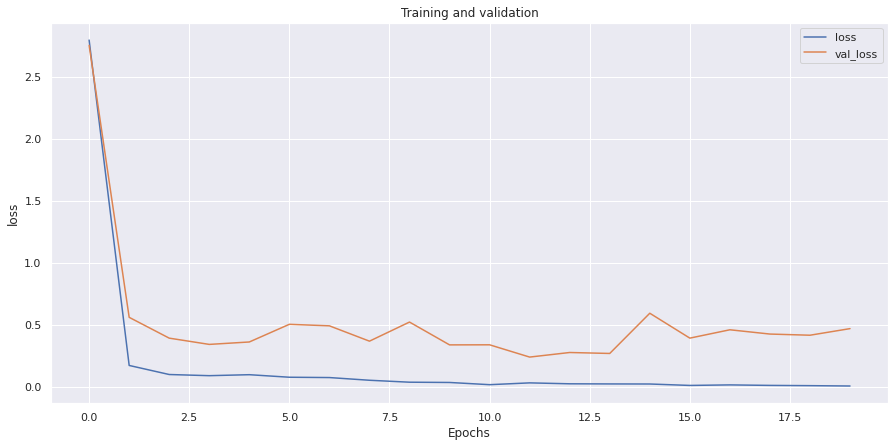

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_irnv2lr.save("irnv2lr.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
irnv2lr_model = load_model('irnv2lr.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = irnv2lr_model.evaluate(test_batches_irnv2, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 16s 501ms/step - loss: 1.2147 - accuracy: 0.7613
test loss: 1.2147489786148071
test acc: 0.7612903118133545


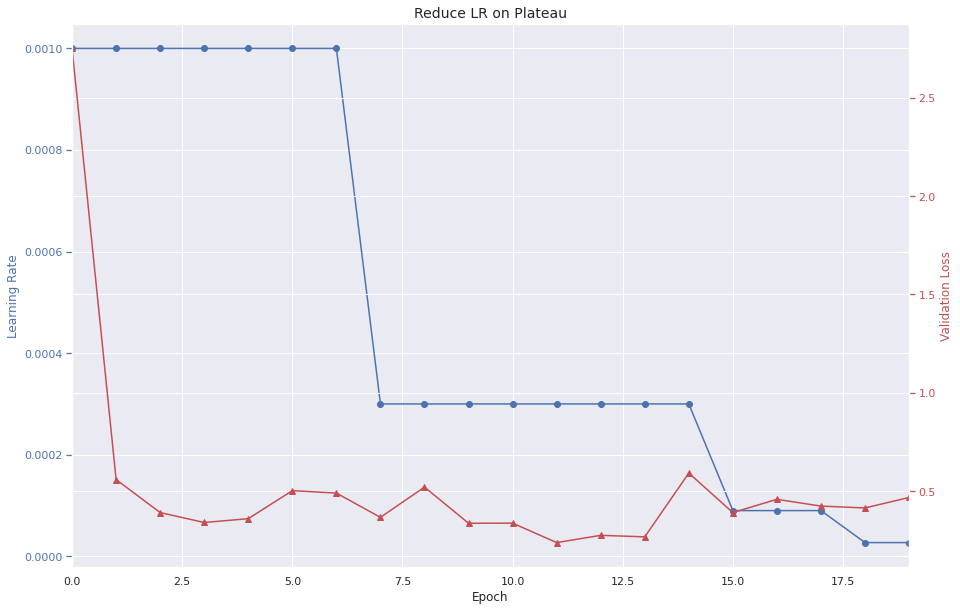

In [ ]:
# Graph learning rate scheduler results
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

Again, our another pretrained model produces a disappointing result. While the learning rate fluctuates epoch to epoch, there's no clear indication as to which learning rate is better.

### Final Model

After the surprising poor performances of our pretrained models, it appears that our inital (and simplest) model is easily our best. We'll run it one last time with the new learning rate of 0.0001 that we determined earlier.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_batches = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(128, 128), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
model = keras.Sequential([
    # Block 1
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Fully-connected NN
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(3, activation='softmax')  
])

In [ ]:
# Complile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='initlr.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ), 
    keras.callbacks.ReduceLROnPlateau(
        factor=0.3, patience=3)
]

n_epochs=20

history = model.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=n_epochs,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      callbacks=callbacks_list,
      verbose=1)

Epoch 1/20
73/73 [==============================] - 36s 489ms/step - loss: 0.3540 - accuracy: 0.8801 - val_loss: 1.0535 - val_accuracy: 0.5851

Epoch 00001: val_loss improved from inf to 1.05348, saving model to initlr.h5
Epoch 2/20
73/73 [==============================] - 35s 481ms/step - loss: 0.0992 - accuracy: 0.9653 - val_loss: 1.0448 - val_accuracy: 0.4420

Epoch 00002: val_loss improved from 1.05348 to 1.04484, saving model to initlr.h5
Epoch 3/20
73/73 [==============================] - 35s 483ms/step - loss: 0.0553 - accuracy: 0.9837 - val_loss: 1.0903 - val_accuracy: 0.5425

Epoch 00003: val_loss did not improve from 1.04484
Epoch 4/20
73/73 [==============================] - 35s 479ms/step - loss: 0.0465 - accuracy: 0.9833 - val_loss: 0.6933 - val_accuracy: 0.6662

Epoch 00004: val_loss improved from 1.04484 to 0.69326, saving model to initlr.h5
Epoch 5/20
73/73 [==============================] - 35s 483ms/step - loss: 0.0246 - accuracy: 0.9953 - val_loss: 0.3725 - val_accur

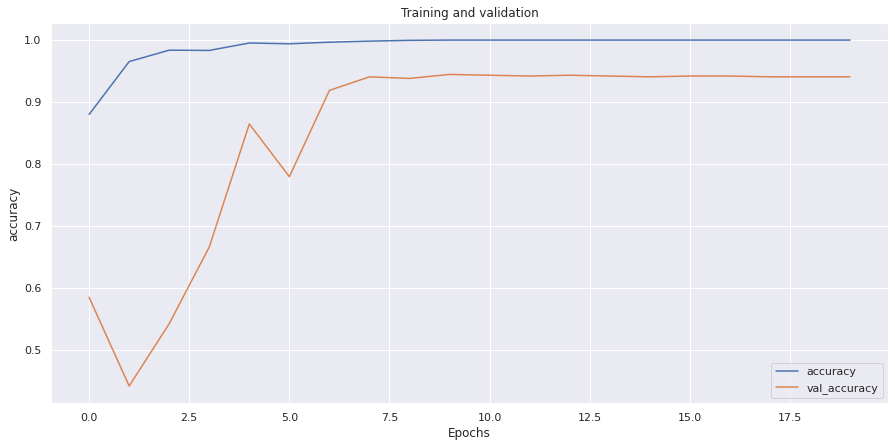

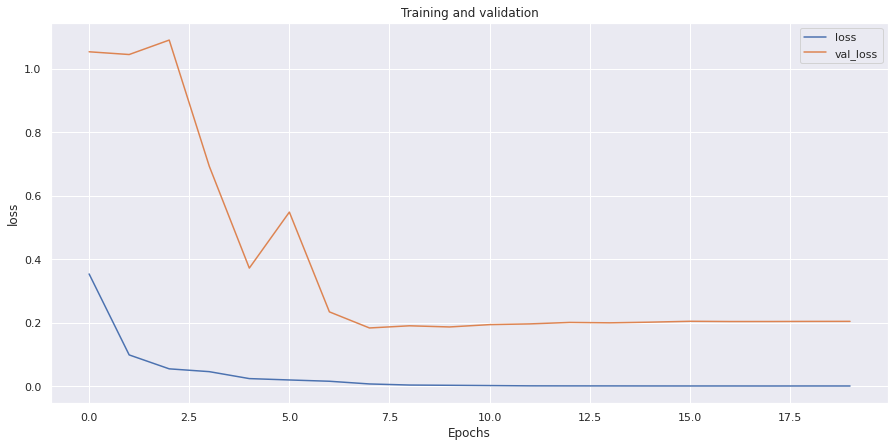

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model.save("initlr.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
initlr_model = load_model('initlr.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = initlr_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 10s 391ms/step - loss: 0.1901 - accuracy: 0.9535
test loss: 0.19013309478759766
test acc: 0.9535483717918396


This is the highest accuracy that we've achieved with any model. While there is still a decent amount of overfitting, the model is actually fairly stable after a few epochs, much more stable than many of our previous models. Accuracy in the mid 90's is respectable. It may not be strong enough for this model to be used in a medical setting, but given the limited amount of time and resources available to develop the model, it's solid.  

### Further Exploration

Surprisingly, our intial model ended up being our most successful. It's not entirely clear why that's the case. There are several options that we could still pursue to improve the accuracy further, and, perhaps, some of those methods would shed more light on why the pretrained models performed so poorly. These methods include trying different image augmentation hyperparameters, running the model for a greater number of epochs (especially the learning rate scheduler), changing the layers at the top of our model, using different optimizers and loss functions, and implementing test-time augmentation. We also didn't try using our pretrained models without Imagenet weights. It's unlikely that not including the weights would increase the accuracy, but it may be worth a shot on at least one model. But for our purposes, we'll stop here and perhaps revisit this project in the future.  